In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sample_submission.csv")


#### Hold-out validation vs. K-folding validation

*Hold-out validation* implica separar el dataset (ya sin los datos de test) en dos partes: una parte para entrenar y otra parte para validar. La idea es justamente entrenar el modelo con el dataset de *train* y luego poder evaluarlo con el dataset de validación.

*K-folding validation* o validación cruzada es separar al dataset en k partes iguales seleccionadas de forma aleatoria. Una de esas partes será el dataset de validación y el resto conformará el dataset de *train*. Pero, a diferencia del otro método, en este caso se repetirá el proceso de entrenamiento y validación k veces, de forma que cada una de las partes sea el dataset de validación una vez.

Claramente la diferencia principal es que mientras en hold-out se usa solamente una partición train-validate (la perfomance medida dependerá en cierta medida de cómo se haga esta partición), en k-folding se usan k particiones. En este sentido, k-folding permite ver cómo se comporta el modelo sin haber entrenado con cada uno de los datos del dataset. 

Por otro lado, hold-out consume menor poder de cómputo y en consecuencia requiere menos tiempo. Hold-out funcionará bien cuando el dataset es grande, ya que no se observarán diferencias al incluir en train los datos de validación.

[Hold-out vs. Cross-validation in Machine Learning](https://medium.com/@eijaz/holdout-vs-cross-validation-in-machine-learning-7637112d3f8f#:~:text=Cross%2Dvalidation%20is%20usually%20the,just%20one%20train%2Dtest%20split.)

In [2]:
list_classes = [
    "toxic",
    "severe_toxic",
    "obscene",
    "threat",
    "insult",
    "identity_hate"
    ]
y = train[list_classes].values
X_train, X_valid, y_train, y_valid =\
    train_test_split(train, y, test_size=0.1, random_state=10, shuffle=True)

train_text = X_train["comment_text"].str.lower()
valid_text = X_valid["comment_text"].str.lower()
test_text = test["comment_text"].str.lower()

#### Stemming & Lemmatization

- https://www.geeksforgeeks.org/nlp-how-tokenizing-text-sentence-words-works/
- https://www.geeksforgeeks.org/introduction-to-stemming/?ref=gcse
- https://www.geeksforgeeks.org/python-stemming-words-with-nltk/?ref=gcse
- https://www.researchgate.net/publication/284038938_A_Comparative_Study_of_Stemming_Algorithms
- https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8


In [3]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
#from nltk.stem.wordnet import WordNetLemmatizer

#wnl = WordNetLemmatizer()
snowball = SnowballStemmer(language="english")

def my_tokenizer(text: str) -> list:
    '''
    my_tokenizer separa una cadena de texto en sus palabras. En exte contexto,
    una palabra son dos o más letras (del alfabeto inglés) consecutivas.
    Devuelve una lista con las raíces (stems) de las palabras, omitiendo
    las palabras de stop_words.

    :param text: cadena de texto a tokenizar
    :type text: str
    :return: lista de stems
    :rtype: list
    '''
    regexp_tokenizer = RegexpTokenizer(pattern=r"[a-zA-Z]{2,}")
    terms = regexp_tokenizer.tokenize(text)
    stop_words = stopwords.words("english")
    stems = []
    for term in terms:
        if term in stop_words:
            continue
        stem = snowball.stem(term)
        if len(stem)>2 and stem not in stop_words:
            stems.append(stem)
    return stems

#### Bag of Words

Para poder convertir los comentarios en una entrada numérica (una matriz) para la red neuronal, es necesario:
* **Tokenizar** cada documento (separar en palabras). En este caso se toma como una palabra dos o más letras seguidas.

```python
regexp_tokenizer = RegexpTokenizer(pattern=r"[a-zA-Z]{2,}")
terms = regexp_tokenizer.tokenize(text)
```

* **Contar** las ocurrencias de cada token en el documento.
* **Normalizar** el texto, es decir, asignar menor importancia a los tokens muy comunes.

De esta manera, cada documento de texto se puede representar a través de un vector donde cada número mide la cantidad de ocurrencias de la palabra en el documento (usando CountVecorizer) o da una medida de la importancia de esa palabra. Luego un conjunto de documentos se podrá representar como una matriz. Esta forma de representación se llama Bag of Words.



#### Count Vectorizer vs TF-IDF

Count Vectorizer sirve para contar la cantidad de ocurrencias de cada palabra en conjunto de documentos de texto. En cambio, si bien TD-IDF (Term Frequency - Inverse Document Frequency) también se basa en la cantidad de concurrencias, provee una medida de la importancia de cada palabra. Si una palabra es muy frecuente, podemos pensar que observarla es un hecho que no aporta mucha información. Por otro lado, si una palabra ocurre con muy poca frecuencia, no es conveniente incluirla en el modelo ya que no será posible hacer buenas predicciones a partir de este tipo de palabras.

Para cada token $t$ de cada documento $d$ se calcula:

$\text{tf-idf}(t,d)=\text{tf}(t,d)\times \text{idf}(t)$

Donde el *term frequency* será la cantidad de ocurrencuas del token en el documento, y en *inverse document frequency* es una medida de la frecuencia del token en todo el conjunto de documentos.

$\text{idf}(t)=\log\frac{1+N}{1+\text{df}(t)}+1$

Donde el *document frequency* es la cantidad de documentos donde aparece el token y $n$ es el número de documentos.

TfidfTransform aplica esta transformación a una matriz que resulta de CountVectorizer.vectorize(). TfidfVectorizer reúne ambas operaciones. Ejemplo simple:

```python
tfidf_vectorizer_example = TfidfVectorizer(
    lowercase=True,
    strip_accents="ascii",
    tokenizer=my_tokenizer,
)

docs = train_text[100:103]

matrix_example = tfidf_vectorizer_example.fit_transform(raw_documents=docs)
 
tfidf_matrix_example = pd.DataFrame(
    matrix_example.todense(),
    columns=tfidf_vectorizer_example.get_feature_names_out()
)
```

Para concluir, TfidfVectorizer es superior a CountVectorizer ya que incorpora una medida de la información que agrega cada palabra en el conjunto de documentos utilizado. Esta información adicional se reflejará luego en las direcciones más importantes de la matriz al aplicar SVD para reducir la dimensionalidad.

Referencias:

* [Text feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

##### Gráfico de #palabras en función del document frequency (df)

Obtenido a partir de la matriz de CountVectorizer habiendo aplicado my_tokenizer


In [43]:
# from sklearn.feature_extraction.text import CountVectorizer

# cv = CountVectorizer(
#     lowercase=True,
#     strip_accents="ascii",
#     stop_words="english",
#     max_df=0.01,
#     min_df=10,
#     #max_features=200000,
#     tokenizer=my_tokenizer,
# )
# matrix2 = cv.fit_transform(raw_documents=train_text)
# print(matrix2.shape)

import numpy as np
from scipy import sparse

cv_matrix = sparse.load_npz("cv_matrix.npz") # matriz dada por CV con min_df=1 y max_df=1.0
matrix_df = cv_matrix != 0 # para cada documento y cada palabra, True si pertenece
df = matrix_df.sum(axis=0).tolist()[0] # cuento en cuantos documentos aparece cada palabra
print(f"{len(df)} different words in train")

n_docs = cv_matrix.shape[0]
x = []
y = []
y2 = []
for i in range(1, n_docs//10):
    n_words = df.count(i) # cantidad de palabras que aparecen en exactamente i documentos
    if n_words > 0:
        x.append(i / n_docs * 100) # % of documents
        y.append(np.log10(n_words)) # logarithmic measure
        y2.append(n_words)


125137 different words in train


El gráfico obtenido sirve para entender la distribucón de las palabras en los documentos y poder elegir min_df y max_df en TfidfVectorizer.

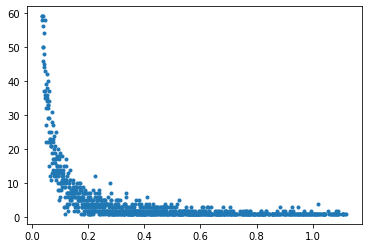

In [60]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(x[50:1000], y2[50:1000], '.')

Count & Normalize

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    strip_accents="ascii",
    max_df=0.05,
    min_df=50,
    tokenizer=my_tokenizer,
)
matrix_train = tfidf_vectorizer.fit_transform(raw_documents=train_text)
matrix_valid = tfidf_vectorizer.transform(raw_documents=valid_text)
matrix_test = tfidf_vectorizer.transform(raw_documents=test_text)

feature_names = tfidf_vectorizer.get_feature_names_out()

#### Singular Value Decomposition (SVD)

A partir de SVD, se reduce la dimensionalidad de las matrices de tfidf a partir de sus direcciones más importantes.

In [17]:
from sklearn.decomposition import TruncatedSVD

trunSVD = TruncatedSVD(
    n_components=500,
    #random_state=10,
    )
dense_matrix_train = trunSVD.fit_transform(matrix_train)
dense_matrix_valid = trunSVD.transform(matrix_valid)
dense_matrix_test = trunSVD.transform(matrix_test)

#### Modelo

In [6]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from keras import regularizers
from keras import initializers

default_initializer = initializers.normal(mean=0, stddev=0.001)
# default_initializer = 'zeros'

input_features = dense_matrix_train.shape[1]
output_size = y_train.shape[1]
hidden_units = 100
lambd = 0 #0.001
model_sig_nn = Sequential()
model_sig_nn.add(Dense(200,
                       input_dim=input_features, 
                       kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=default_initializer,
                       name="Capa_Oculta_1"))
model_sig_nn.add(Activation('relu'))
model_sig_nn.add(Dense(200,
                       input_dim=input_features, 
                       kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=default_initializer,
                       name="Capa_Oculta_2"))
model_sig_nn.add(Activation('relu'))
model_sig_nn.add(Dense(output_size,
                       kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=default_initializer,
                       name="Capa_Salida"))
model_sig_nn.add(Activation('sigmoid', name="output")) 
model_sig_nn.summary()


lr = 0.001 
batch_size = 128
epochs = 10

selectedOptimizer = tf.keras.optimizers.Adam(learning_rate=lr, decay=0.001)

model_sig_nn.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, 
                     metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Oculta_1 (Dense)       (None, 200)               60200     
                                                                 
 activation (Activation)     (None, 200)               0         
                                                                 
 Capa_Oculta_2 (Dense)       (None, 200)               40200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 Capa_Salida (Dense)         (None, 6)                 1206      
                                                                 
 output (Activation)         (None, 6)                 0         
                                                                 
Total params: 101,606
Trainable params: 101,606
Non-trai

#### Train

In [7]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(
    filepath='basic_model_best.hdf5',
    verbose=1,
    save_best_only=True
)

history = model_sig_nn.fit(dense_matrix_train, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(dense_matrix_valid, y_valid),
          callbacks=[
              checkpointer
              ],
         )

Epoch 1/10
1113/1122 [============================>.] - ETA: 0s - loss: 0.1005 - accuracy: 0.9783
Epoch 1: val_loss improved from inf to 0.06848, saving model to basic_model_best.hdf5
1122/1122 [==============================] - 5s 4ms/step - loss: 0.1003 - accuracy: 0.9784 - val_loss: 0.0685 - val_accuracy: 0.9945
Epoch 2/10
1117/1122 [============================>.] - ETA: 0s - loss: 0.0643 - accuracy: 0.9941
Epoch 2: val_loss improved from 0.06848 to 0.06116, saving model to basic_model_best.hdf5
1122/1122 [==============================] - 4s 4ms/step - loss: 0.0643 - accuracy: 0.9941 - val_loss: 0.0612 - val_accuracy: 0.9945
Epoch 3/10
1117/1122 [============================>.] - ETA: 0s - loss: 0.0602 - accuracy: 0.9941
Epoch 3: val_loss improved from 0.06116 to 0.05962, saving model to basic_model_best.hdf5
1122/1122 [==============================] - 4s 4ms/step - loss: 0.0602 - accuracy: 0.9941 - val_loss: 0.0596 - val_accuracy: 0.9945
Epoch 4/10
1120/1122 [===================

#### Evaluar el dataset de validación

In [16]:
model_sig_nn.load_weights('basic_model_best.hdf5')
loss, val_accuracy = model_sig_nn.evaluate(dense_matrix_valid, y_valid)
print(f"Loss={loss} | Val_accuracy={val_accuracy}")

499/499 [==============================] - 1s 3ms/step - loss: 0.0582 - accuracy: 0.9945
Loss=0.0582379475235939 | Val_accuracy=0.9944854974746704


#### Curva ROC (Receiver Operating Characteristic)

Para una clasificación binaria tenemos una probabilidad de que el comentario pertenezca a esa categoría. Para medir que tan bueno es el modelo para clasificar los comentarios usamos la curva ROC.

La curva ROC es una representación gráfica de la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR), a medida que movemos el umbral de decisión (valor límite entre positivo y negativo). La tasa de verdaderos positivos nos indica el porcentaje de verdaderos positivos respecto del total de positivos en esa categoría. La tasa de falsos positivos nos indica el porcentaje de falsos positivos respecto del total de negativos en esa categoría.

[Interpretación gráfica en Desmos](https://www.desmos.com/calculator/juezsoefn5)

<img src="images/desmos-graph.png" style="width: 300px; height=300px;"/>

Las curvas roja y verde representan las distribuciones de positivos y negativos para dada clasificación. El umbral de decisión es la recta vertical negra. El área verde oscuro corresponde a los verdaderos positivos (TP) y el área rojo oscuro representa a los falsos positivos (FP). Por el contrario, el área verde claro son los falsos negativos (FN) y el área rojo claro son los verdaderos negativos (TN).

El punto de la curva ROC es $(\text{FPR}, \text{TPR})$, donde

$\text{TPR}=\frac{\text{TP}}{\text{TP}+\text{FN}}$
$\text{FPR}=\frac{\text{FP}}{\text{TN}+\text{FP}}$

La curva ROC se construye variando el umbral de decisión entre 0 y 1 (ver en Desmos).

Si las dos distribuciones están completamente separadas la curva ROC es un cuadrado.

La gran ventaja de la curva ROC es que no cambia si cambia la proporción entre positivos y negativos en la clasificación. Por ejemplo la proporción de comentarios insultantes entre el total de comentarios.

La métrica de la competencia es la media de las ROC-AUC o AUROC (Area Under the Receiver Operating Characteristics). Es decir que se promedian las áreas debajo de cada una de las 6 curvas ROC correspondientes a las 6 clasificaciones.

Como ya se mencionó, el AUROC es máximo y vale 1 cuando las distribuciones son perfectamente separables por algún umbral de decisión. El peor AUROC es 0.5 ya que en ese caso el modelo no tiene ninguna capacidad de separar (clasificar).

[ROC-AUC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

#### F1-Score

Se calcula la precisión (precison) como la medida de positivos que son verdaderos: $\frac{\text{TP}}{\text{TP}+\text{FP}}$.

Se calcula la exhaustividad (recall) como la cantidad de verdaderos que son identificados como positivos: $\frac{\text{TP}}{\text{TP}+\text{FN}}=\text{TPR}$.

El F1-Score combina las dos métricas anteriores: $\text{F1}=2\cdot\frac{\text{precison}\cdot\text{recall}}{\text{precison}+\text{recall}}$

La métrica F1-Score asume que nos interesa en igual medida la precisión y la exhaustividad. Dependiendo de la aplicación este puede no ser el caso. Existe $\text{F}_\beta\text{-Score}$.

Una diferencia importante entre F1-Score y ROC-AUC es que el primero necesita saber si el dato pertenece o no a la categoría (es decir, se debe fijar el umbral de decisión) para calcular el score, mientras que el segundo se basa en las probabilidad dada de que pertenezca a la categoría. No obstante, se puede construir una curva Precisión-Exhaustividad para cada umbral de decisión.

* https://www.iartificial.net/precision-recall-f1-accuracy-en-clasificacion/
* https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc
* https://medium.com/swlh/recall-precision-f1-roc-auc-and-everything-542aedf322b9

In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

pred_valid = model_sig_nn.predict(dense_matrix_valid, verbose = 1)
pred_train = model_sig_nn.predict(dense_matrix_train, verbose = 1)

print(roc_auc_score(y_train, pred_train, average='macro'))
print(roc_auc_score(y_valid, pred_valid, average='macro'))

4488/4488 [==============================] - 8s 2ms/step
0.9718489031042687
0.963932396169143


In [10]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_valid.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid[:, i], pred_valid[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid.ravel(), pred_valid.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18176\2851730522.py:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


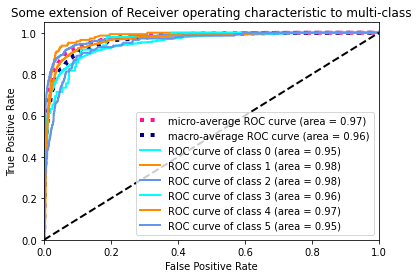

In [11]:
from matplotlib import pyplot as plt
# Compute macro-average ROC curve and ROC area
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [12]:
pred_test = model_sig_nn.predict(dense_matrix_test, verbose = 1)
submission[list_classes] = pred_test
submission.to_csv("submissions/submission_.csv", index=False)

Submission details: 

Submission 1: mindf = 20. Using Lemmatization, stopwords, TFIDF, sigmoid activation function and Adam

Submission 2: mindf = 10. Add RELU as the activation function and Adam 

Submission 3: mindf = 20

Submission 4: 500 components in SVD

Submission 5: 300 components in SVD and maxdf=2% mindf=20

Submission 6: maxdf 5% mindf 30

Submission 7: maxdf 5% mindf 200

Submission 8:  maxdf 5% mindf 50